# Example Notebook to fit a microlensing event

The procedure is:
1. Estimate the point lens parameters (`t_0`, `u_0`, `t_E`) from the light curve.
2. Fit a point lens model (excluding the planetary perturbation).
3. Estimate the planet parameters (`s`, `alpha`) from the light curve.
4. Search for the best planetary model using a grid of `s`, `q` (fixed parameters); fits for `rho` and `alpha` but holds the PSPL parameters (`t_0`, `u_0`, `t_E`) fixed.

This notebook is setup to run on a simulated data file: `WFIRST_1827.dat`. To run it on a different data file requires some limited user interaction indicated by `***`:
1. Set `filename` and `path`
2. Set the plot limits: `t_min`, `t_max`
3. Define the time window of the planetary perturbation: `t_planet_start`, `t_planet_stop`

The goal of the notebook is to demonstrate the procedure and run quickly, so it is not robust. The fitting procedure is very simplistic and relies on assuming this is a Gould & Loeb (1996) type planet, which means
- It is a planetary caustic perturbation
- It is well described as a _perturbation_, which means
  - The perturbation data can be isolated from the underlying PSPL event 
  - The location of the planet can be estimated from the location of the images at the time of the perturbation
  
This notebook will **not** perform well for:
- central caustic planets (u_0 << 1 and/or u_0 < rho)
- resonant caustic planets (s ~ 1)
- binaries (i.e. the assumption that q << 1 is false)

Simple modifications that could improve performance indicated by `*`:
- Change the `magnification_methods`, i.e. the method used and the time range it is used for.
- Change the minimization routine in `fit_model()` (This notebook is set up to use a 'Nelder-Mead' simplex algorithm. Simplex algorithms are known to perform poorly on microlensing events.)
- Change the size of the grid or the grid steps: `delta_log_s`, `delta_log_q`, `grid_log_s`, `grid_log_q`

In [1]:
# Import packages
from datetime import datetime
start_time = datetime.now() # initialize timer
import MulensModel as mm
import matplotlib.pyplot as pl
import numpy as np
import scipy.optimize as op
import os
import astropy.units as u
import sys
from scipy.stats import chisquare
from datetime import datetime
from astropy.coordinates import SkyCoord
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit
import emcee
from MulensModel.utils import Utils


In [29]:
class color:
   PURPLE = '\033[1;35;48m'
   CYAN = '\033[1;36;48m'
   BOLD = '\033[1;37;48m'
   BLUE = '\033[1;34;48m'
   GREEN = '\033[1;32;48m'
   YELLOW = '\033[1;33;48m'
   RED = '\033[1;31;48m'
   BLACK = '\033[1;30;48m'
   UNDERLINE = '\033[4;37;48m'
   END = '\033[1;37;0m'

In [2]:
np.set_printoptions(threshold=sys.maxsize)

#Define fitting functions

def chi2_fun(theta, event, parameters_to_fit):
    """                                                                         
    Chi2 function. Changes values of the parameters and recalculates chi2.
    
    event = a MulensModel.Event
    parameters_to_fit = list of names of parameters to be changed
    theta = values of the corresponding parameters
    """
    # key = the name of the MulensModel parameter
    for (index, key) in enumerate(parameters_to_fit):
        if (key == 't_E' or key =='rho') and theta[index] < 0.:
            return np.inf 
        setattr(event.model.parameters, key, theta[index])
    return event.get_chi2(fit_blending = True)

def fit_model(event, parameters_to_fit):
    """
    Fit an "event" with "parameters_to_fit" as free parameters.
    
    event = a MulensModel event
    parameters_to_fit = list of parameters to fit
    """
    # Take the initial starting point from the event.
    x0 = []
    for key in parameters_to_fit:
        value = getattr(event.model.parameters, key)
        if isinstance(value, u.Quantity):
            x0.append(value.value)
        else:
            x0.append(value)

    # *Execute fit using a 'Nelder-Mead' algorithm*
    result = op.minimize(
        chi2_fun, x0=x0, args=(event, parameters_to_fit),
        method='Nelder-Mead')

    return result

In [21]:
# ***Read in data file***
#path = os.path.join(mm.MODULE_PATH, "data")
path = '/Users/adrianhernandez/JPL_2021/ukirt_files'
filenames = 'UK2017_s3_3_1_H_C38760.txt' # Planet file
file = os.path.join(path, filenames)
data = mm.MulensData(file_name=file)
filename = 'UK2017_s3_3_1_H_C38760'


In [27]:
data_points = len(data.time)

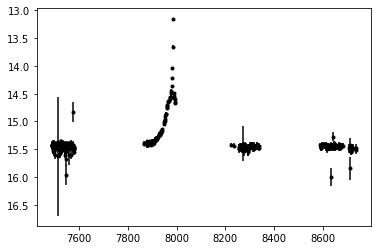

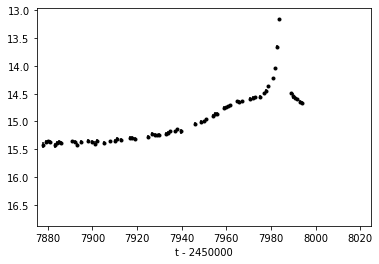

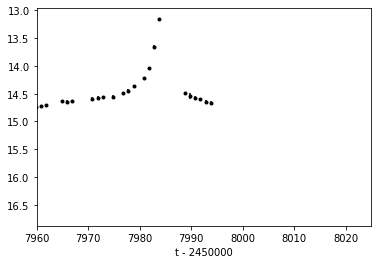

In [23]:
# Plot the data
pl.errorbar(data.time - 2450000, data.mag, yerr=data.err_mag, fmt='.k')
pl.gca().invert_yaxis()
pl.show()

# ***Define plot limits for a zoom (of the planetary perturbation)***

# Plot a zoom of the data
pl.errorbar(data.time -2450000, data.mag, yerr=data.err_mag, fmt='.k')
pl.xlim(7875,8025)
pl.xlabel('t - 2450000')
pl.gca().invert_yaxis()
pl.show()

pl.errorbar(data.time -2450000, data.mag, yerr=data.err_mag, fmt='.k')
pl.xlim(7960,8025)
pl.xlabel('t - 2450000')
pl.gca().invert_yaxis()
pl.show()

In [24]:
# ***Set time range of planetary perturbation (including 2460000).***
(t_planet_start, t_planet_stop) = (2457980,2457990)

# *Set the magnification methods for the planet model*
# VBBL method will be used between t_planet_start and t_planet_stop, 
# and point_source_point_lens will be used everywhere else.
magnification_methods = [
    0., 'point_source_point_lens', 
    t_planet_start, 'VBBL', t_planet_stop, 
    'point_source_point_lens', 2458800.]

In [25]:
# Flag data related to the planet
flag_planet = (data.time > t_planet_start) & (data.time < t_planet_stop) | np.isnan(data.err_mag)

# Exclude those data from the fitting (for now)
data.bad = flag_planet

In [32]:
base_est = np.mean(data.mag) 
print(color.BLUE +'Estimated Baseline magnification ='+ color.END,base_est)
peak_est = min(data.mag)
print(color.BLUE +'Estimated Event peak magnification ='+ color.END,peak_est)
del_mag_est = base_est - 14.5 #base_est - peak_est 
print(color.BLUE +'Estimated Change in magnification ='+ color.END,del_mag_est)
to_est = 2458305 #time[mag.argmin()] #2458588.82653
print(color.BLUE +'Estimated Time at which peak magnification occurs ='+ color.END,to_est)
A_FWHM = (base_est + 14.5)/2
print(color.BLUE +'FWHM occurs at'+ color.END,A_FWHM)
width = np.full((1,data_points),A_FWHM)
idx = np.argwhere(np.diff(np.sign(width - data.mag))).flatten()
print(data.time[idx])
FWHM = data.time[idx][7]- data.time[idx][0]
print(color.BLUE +'The estimated FWHM is'+ color.END,FWHM)
sig_est = FWHM/2.355
print(color.BLUE +'The estimated simga is'+ color.END,sig_est)

Estimated Baseline magnification = 15.365941002949853
Estimated Event peak magnification = 13.162
Estimated Change in magnification = 0.8659410029498531
Estimated Time at which peak magnification occurs = 2458305
FWHM occurs at 14.932970501474927
[2457864.08531 2457950.87666 2457864.08531 2457993.84897 2457864.08531
 2457574.96169 2457864.08531 2457575.89911]
The estimated FWHM is -288.18619999988005
The estimated simga is -122.37205944793207


In [ ]:
##best fit u0,t0,tE for UK2017_c4_2_4_K_C97661

#u0 = 0.020281678356805336 t0 = 7916.003482491854 tE = 108.3975092117566

In [33]:
# Estimate point lens parameters assuming zero blending
# 
# Equation for point lens magnification:
#
# A(u) = (u^2 + 2) / (u * sqrt(u^2 + 4))
#
# where
# 
# u = sqrt(u_0^2 + tau^2) and tau = (t - t_0) / t_E
#
# Thus, the light curve is defined by 3 variables: t_0, u_0, t_E
#

# Estimate t_0 (time of peak magnification)
index_t_0 = np.argmin(data.mag)
t0_est = data.time[index_t_0]

# Estimate u_0
baseline_mag = np.min([data.mag[0], data.mag[-1]]) # A crude estimate
A_max =10.**((data.mag[index_t_0] - baseline_mag) / -2.5)
u0_est = 1. / A_max # True in the high-magnification limit

# Estimate t_E by determining when the light curve is A(t) = 1.3 (i.e. delta_mag = 0.3)
t_1 = np.interp( baseline_mag - 0.3, data.mag[index_t_0:0:-1], data.time[index_t_0:0:-1])
tE_est = np.abs((t0_est - t_1) / np.sqrt(1. - u0_est**2))

print(t0_est,u0_est,tE_est)

2457983.81426 0.12752637064597316 40.548639151332615


(array([180.58823318]), 250.00583302691427)
Initial Guess
    t_0 (HJD)       u_0    t_E (d) 
2457983.81426  0.127526    40.5486 



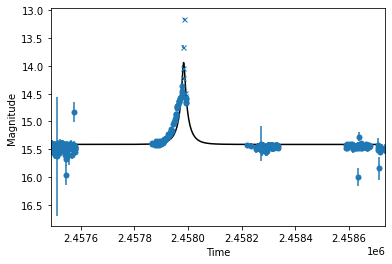

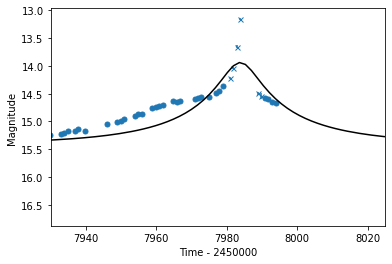

In [37]:
# Define the Point Lens Model
point_lens_model = mm.Model({'t_0': t0_est, 'u_0':u0_est, 't_E':tE_est})
point_lens_event = mm.Event(datasets=data, model=point_lens_model)

print(point_lens_event.get_ref_fluxes(data_ref=None))

print('Initial Guess')
print(point_lens_model)

# Plot (excluded data shown as 'X')
point_lens_event.plot_model(t_range = [2457000,2458700],color='black')
point_lens_event.plot_data(show_bad=True)
pl.show()

point_lens_event.plot_model(t_range = [2457000,2458700],subtract_2450000=True, color='black', zorder=10)
point_lens_event.plot_data(show_bad=True, subtract_2450000=True)
pl.xlim(7930,8025)
pl.show()

    t_0 (HJD)       u_0    t_E (d) 
2457979.83072  0.477334    42.4316 



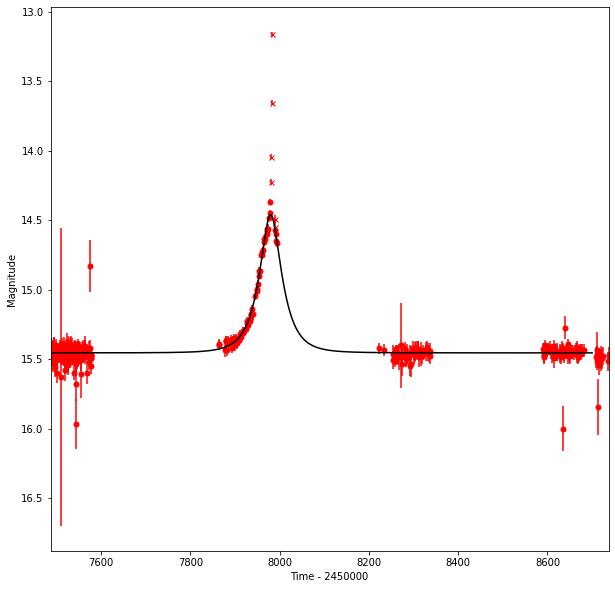

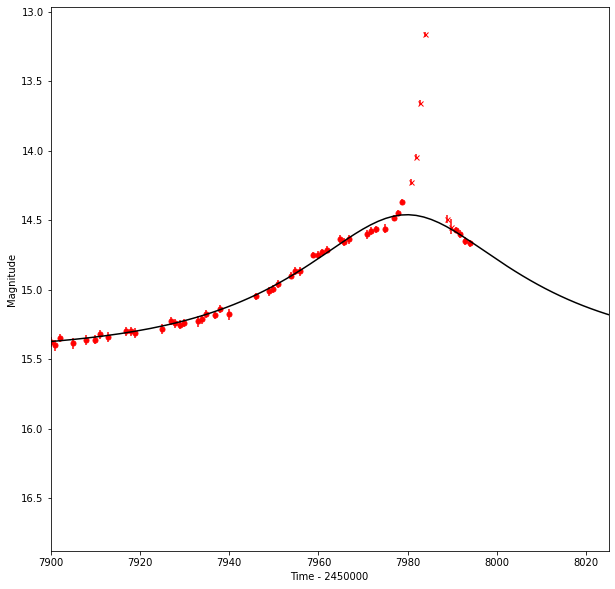

In [49]:
# Fit the Point Lens Model
result = fit_model(point_lens_event, parameters_to_fit=['t_0', 'u_0', 't_E'])
#print(result)
print(point_lens_event.model.parameters)
#print('Best-fit Point Lens')
#print(point_lens_event.model)

#plot full data 

pl.figure(figsize=(10,10))
point_lens_event.plot_model(t_range=[2457000,2458700],subtract_2450000=True,color='black', zorder=10)
point_lens_event.plot_data(show_bad=True,subtract_2450000=True, color= 'red', s = 5)
pl.show()

# Plot zoom 
pl.figure(figsize=(10,10))
point_lens_event.plot_model(t_range=[2457000,2458700],subtract_2450000=True,color='black', zorder=10)
point_lens_event.plot_data(show_bad=True,subtract_2450000=True, color= 'red', s = 5)
pl.xlim(7900,8025)
pl.show()


In [ ]:
my_pspl_model = mm.Model({'t_0': 2458300, 'u_0':6, 't_E': 2.5})
my_event = mm.Event( datasets=[data], model=my_pspl_model)
my_event.plot_model(t_range=[2458230,2458350], subtract_2450000=True, color='black')
my_event.plot_data(subtract_2450000=True, show_bad=True, color_list=['red'], s=5)
pl.xlim(8230,8350)
pl.ylim(16.0,13.0)

In [ ]:
import emcee

In [ ]:
import mcmcFit as mcfit

u0,t0,tE,Ftot,fb,u0err,t0err,tEerr,Ftoterr,fberr = mcfit.mcmcFit(filename,data.time - 2450000,data.mag,data.err_mag,6,2458300 - 2450000,2.5)

print('u0, error',u0,u0err)
print('t0, error',t0,t0err)
print('tE, error',tE,tEerr)
print('Ftot, error',Ftot,Ftoterr)
print('Fb, error',fb,fberr)

In [ ]:
print(u0,t0,tE)

In [ ]:
# point_lens_model = mm.Model({'t_0': 2458300, 'u_0':u0, 't_E': tE})
# point_lens_event = mm.Event(datasets=[data], model=point_lens_model)
# pl.figure(figsize=(10,10))
# point_lens_event.plot_model( subtract_2450000=True, color='black')
# point_lens_event.plot_data(subtract_2450000=True, color_list=['red'],  s=5)
# pl.legend(loc='best')
# pl.show()
# print('PSPL Fitted Parameters')
# print(point_lens_model)

point_lens_model = mm.Model({'t_0': 2458300, 'u_0':.06, 't_E':90})
point_lens_event = mm.Event(datasets=[data], model=point_lens_model)
pl.figure(figsize=(10,10))
point_lens_event.plot_data(subtract_2450000=True, color_list=['red'],  s=5)
point_lens_event.plot_model( subtract_2450000=True, color='black')
pl.legend(loc='best')
pl.xlim(8200,8400)
pl.show()



In [ ]:
# Un-flag planet data (include it in future fits)
data.bad = np.isnan(data.err_mag)

print(point_lens_event.model.parameters.t_0)
print(point_lens_event.model.parameters.t_E)
print(point_lens_event.model.parameters.u_0)

In [ ]:
# Estimate s (projected separation) of the planet, alpha (angle of source trajectory)

# Approximate time of the planetary perturbation
t_planet = (t_planet_stop + t_planet_start) / 2.

print(t_planet)
# Position of the source at the time of the planetary perturbation
tau_planet = ((t_planet - point_lens_event.model.parameters.t_0) /
              point_lens_event.model.parameters.t_E)
print(tau_planet)
u_planet = np.sqrt(point_lens_event.model.parameters.u_0**2 + tau_planet**2)

# Position of the lens images at the time of the planetary perturbation
# --> Estimate of the planet location
s_minus = 0.5 * (np.sqrt(u_planet**2 + 4.) - u_planet)
s_plus = 0.5 * (np.sqrt(u_planet**2 + 4.) + u_planet)


# Angle between the source trajectory and the binary axis

alpha_planet = np.rad2deg(-np.arctan2(point_lens_event.model.parameters.u_0, tau_planet)) #-180 deg?

print(s_plus,s_minus)
print(alpha_planet)

In [ ]:
# Check the estimated model
# Note that there are two possibilities for s: s_plus and s_minus. 
# Only s_plus is tested here, but both are considered in the grid search below.

# Define the model
test_model = mm.Model({
    't_0': point_lens_event.model.parameters.t_0, 
    'u_0': point_lens_event.model.parameters.u_0,
    't_E': point_lens_event.model.parameters.t_E,
    'rho':10**(-3),
    's': s_plus, #effects the shape of the causitc 
    'q': 10**(-3),
    'alpha': alpha_planet})
test_model.set_magnification_methods(magnification_methods)
test_event = mm.Event(datasets=data, model=test_model)

print(test_event.model)

# Plot the model light curve
pl.figure(figsize=(10,10))
test_event.plot_data(subtract_2450000=True)
test_event.plot_model(t_range=[2457000,2458700],subtract_2450000=True, color='black', zorder=5)
pl.show()


pl.figure(figsize=(10,10))
test_event.plot_data(subtract_2450000=True)
test_event.plot_model(t_range=[2457900,2458700],subtract_2450000=True, color='black', zorder=5)
pl.xlim(8250,8350)
pl.show()


# Plot the trajectory of the source relative to the caustics
test_event.model.plot_trajectory(color='black', caustics=True)
pl.xlim(-.25,.25)
pl.ylim(-.15,.15)
pl.show()
# It doesn't have to be perfect, but there should be a planetary perturbation
# at around the time of the perturbation in the data. If there is no perturbation
# and/or the source trajectory doesn't pass very near/through the caustics, there is some 
# problem with the model and the fit will likely fail.

In [ ]:
# Using the Point Lens fit as input, search for a planetary solution
#
# Grid parameters: s (log), q (log)
# Fit parameters: rho, alpha
# PSPL parameters: t_0, u_0, t_E
#

# *Define the grid*
delta_log_s = 0.001
delta_log_q = 0.03
grid_log_s = np.hstack(
    (np.arange(
        np.log10(s_minus) - 0.01, np.log10(s_minus) + 0.01, delta_log_s),
    np.arange(
        np.log10(s_plus) - 0.01, np.log10(s_plus) + 0.01, delta_log_s)))
grid_log_q = np.arange(-3, -1, delta_log_q)

print(grid_log_s)
print(grid_log_q)

       

In [ ]:
# For each grid point, fit for rho, alpha
grid = np.empty((5, len(grid_log_s) * len(grid_log_q)))
i = 0
print('{0:>12} {1:>6} {2:>7} {3:>7} {4:>7}'.format('chi2', 's', 'q', 'alpha', 'rho'))
for log_s in grid_log_s:
    for log_q in grid_log_q:
        # The major and minor images are on opposite sides of the lens:
        if log_s < 0.:
            alpha = alpha_planet + 180.
        else:
            alpha = alpha_planet
            
        # Define the Model and Event
        planet_model = mm.Model({
            't_0': point_lens_event.model.parameters.t_0, 
            'u_0': point_lens_event.model.parameters.u_0,
            't_E': point_lens_event.model.parameters.t_E,
            'rho': 10**(-3),
            's': 10.**log_s,
            'q': 10.**log_q,
            'alpha': alpha_planet+180})
        planet_model.set_magnification_methods(magnification_methods)
        planet_event = mm.Event(datasets=[data], model=planet_model)
            
        # Fit the Event
        result = fit_model(planet_event, parameters_to_fit=['rho', 'alpha'])
        if result.success:
            chi2 = planet_event.get_chi2(fit_blending = True)
        else:
            chi2 = np.inf
                
        # Print and store result of fit
        print('{0:12.2f} {1:6.4f} {2:7.5f} {3:7.2f} {4:7.5f}'.format(
            chi2, 10.**log_s, 10.**log_q, 
            planet_event.model.parameters.alpha, planet_event.model.parameters.rho))
        grid[0, i] = log_s
        grid[1, i] = log_q
        grid[2, i] = chi2
        grid[3, i] = planet_event.model.parameters.alpha.value
        grid[4, i] = planet_event.model.parameters.rho
        i += 1

In [ ]:
# Identify the best model(s)
index_best = np.argmin(np.array(grid[2,:]))
index_sorted = np.argsort(np.array(grid[2,:]))
print(index_best)

In [ ]:

n_best = 7 
colors = ['magenta', 'green', 'cyan','yellow','purple','red']
if len(colors) < n_best - 1:
    raise ValueError('colors must have at least n_best -1 entries.')

# Plot the grid
fig, axes = pl.subplots(nrows=1, ncols=2)
n_plot = 0
for i in np.arange(2):
    if i == 0:
        index_logs = np.where(grid_log_s < 0.)[0]
        index_grid = np.where(grid[0, :] < 0.)[0]
    else:
        index_logs = np.where(grid_log_s >= 0.)[0]
        index_grid = np.where(grid[0, :] >= 0.)[0]
    
    # Plot chi2 map
    chi2 = np.transpose(
            grid[2, index_grid].reshape(len(index_logs), len(grid_log_q)))

    im = axes[i].imshow(
        chi2, aspect='auto', origin='lower',
        extent=[
            np.min(grid_log_s[index_logs]) - delta_log_s / 2., 
            np.max(grid_log_s[index_logs]) + delta_log_s / 2.,
            np.min(grid_log_q) - delta_log_q / 2., 
            np.max(grid_log_q) + delta_log_q / 2.],
        cmap='viridis', 
        vmin=np.min(grid[2,:]), vmax=np.nanmax(grid[2,np.isfinite(grid[2,:])]))  
    
    # Mark best values: best="X", other good="o"
    if index_best in index_grid:
        axes[i].scatter(grid[0, index_best], grid[1, index_best], marker='x', color='white')
    for j, index in enumerate(index_sorted[1:n_best]):
        if index in index_grid:
            axes[i].scatter(grid[0, index], grid[1, index], marker='o', color=colors[j - 1])
            
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

fig.text(0.5, 0.92, r'$\chi^2$ Map', ha='center')
fig.text(0.5, 0.04, 'log s', ha='center')
fig.text(0.04, 0.5, 'log q', va='center', rotation='vertical')
fig.text(1.1, 0.5, r'$\chi^2$', va='center', rotation='vertical')

pl.show()


In [ ]:
(t_planet_start, t_planet_stop) = (2458275,2458290)

# *Set the magnification methods for the planet model*
# VBBL method will be used between t_planet_start and t_planet_stop, 
# and point_source_point_lens will be used everywhere else.
magnification_methods = [
    2457800., 'point_source_point_lens', 
    t_planet_start, 'VBBL', t_planet_stop, 
    'point_source_point_lens', 2458700.]

def make_grid_model(index):
    """
    Define a Model using the gridpoint information + the PSPL parameters.
    
    index = index of the grid point for which to generate the model
    """
    model = mm.Model({
        't_0': point_lens_event.model.parameters.t_0, 
        'u_0': point_lens_event.model.parameters.u_0,
        't_E': point_lens_event.model.parameters.t_E,
        'rho': grid[4, index],
        's': 10.**grid[0, index],
        'q': 10.**grid[1,index],
        'alpha': grid[3,index]})
    model.set_magnification_methods(magnification_methods)
    return model




In [ ]:
# Plot the best-fit model
best_fit_model = make_grid_model(index_best)
print('Best Models')
print(best_fit_model)
                   

In [ ]:
best_fit_event = mm.Event(datasets=data, model=best_fit_model)
(f_source, f_blend) = best_fit_event.get_ref_fluxes(fit_blending = True)

best_fit_event.plot_model(t_range=[2457000,2458700], subtract_2450000=True, color='black', lw=4)
best_fit_event.plot_data(subtract_2450000=True)
pl.show()

print(best_fit_)

# Zoom of planet
# Best model = black

best_fit_event.plot_model(t_range = [2457000,2458700],subtract_2450000=True, color='black', lw=1, label='best',
    zorder=10)
best_fit_event.plot_data(subtract_2450000=True, s=10, zorder=0,marker_list = 'o',markerfacecolor='none')
pl.xlim(8250,8350)
pl.show()

# Other models (color-coding matches grid)
for j, index in enumerate(index_sorted[1:n_best]):
    model = make_grid_model(index)
    model.plot_lc(t_range= [2458180,2458600],f_source=f_source, f_blend=f_blend,
        subtract_2450000=True, color=colors[j - 1], lw=2)
    best_fit_event.plot_data(subtract_2450000=True, s=10, zorder=0,marker_list = 'o',markerfacecolor='none')
    pl.title('{0} best models'.format(n_best))
    pl.xlim(8250,8350)
    pl.legend(loc='best')
    pl.show()
    print(model)
    

for j, index in enumerate(index_sorted[1:n_best]):
    model.plot_trajectory(color='blue', caustics=True)
    pl.xlim(-.1,.2)
    pl.ylim(-.15,.15)    
    pl.show()


In [ ]:
parameters_to_fit = ['t_0', 'u_0', 't_E', 'rho', 'alpha', 's', 'q']

fits = []
for index in index_sorted[:n_best]:
    model = make_grid_model(index)
    event = mm.Event(datasets=data, model=model)
    print(event.model)
    result = fit_model( 
        event, parameters_to_fit=parameters_to_fit)
    fits.append([result.fun, result.x])
    print(result)

In [ ]:
print(fits)


In [ ]:
# Plot the best-fit model and output the parameters

# Extract best fit
chi2 = [x[0] for x in fits]
fit_parameters = [x[1] for x in fits]
index_best = np.argmin(chi2)

print(fits)




In [ ]:
d

In [ ]:
end_time = datetime.now()
print('Total Runtime: {0}'.format(end_time - start_time))

    t_0 (HJD)       u_0    t_E (d)     rho         s            q alpha (deg) 
2458300.00000  0.060000    90.0000 0.00045   0.92233   0.09549926   -45.02587 

In [ ]:
planet_grid_model = mm.Model({
    't_0': 2458300., 
    'u_0': 0.060000,
    't_E': 90.0000 ,
    'rho': 0.00045  ,
    's':  0.92233  , #effects the shape of the causitc 
    'q': 0.09549926 ,
    'alpha':  -45.02587 })
planet_grid_model.set_magnification_methods(magnification_methods)
planet_grid_event = mm.Event(datasets=data, model=planet_grid_model)

In [ ]:
pl.figure(figsize=(10,10))
planet_grid_event.plot_data(subtract_2450000=True)
planet_grid_event.plot_model(t_range = [2457000,2458700],subtract_2450000=True, color='black', zorder=10)
pl.title(filename + ' initial fit ')
pl.savefig(filename + '_initial_fit', dpi=100)
pl.show()

# Plot zoom of the planet
pl.figure(figsize=(10,10))
planet_grid_event.plot_data(subtract_2450000=True)
planet_grid_event.plot_model(t_range = [2457000,2458700],subtract_2450000=True, color='black', zorder=10)
pl.xlim(8220,8350)
pl.title(filename + ' initial fit zoom')
pl.savefig(filename + '_initial_fit_zoom', dpi=100)
pl.show()

#residuals
pl.figure(figsize=(10,10))
planet_grid_event.plot_residuals(show_errorbars=True,subtract_2450000=True)
pl.xlim(8200,8350)
pl.ylim(-.15,.15)
pl.title(filename + ' initial fit residuals')
pl.savefig(filename + '_initial_fit_res', dpi=100)
pl.show()

pl.figure(figsize=(10,10))
planet_grid_event.plot_trajectory(color='blue', caustics=True)
pl.title(filename + ' initial fit caustic')
pl.savefig(filename + '_initial_fit_caustic', dpi=100)
pl.show()